# Get percentage of fixations for us and for them AUPRC
# Start at a fixed point
# Shorten sequence length

1. Results table 
2. Fine-tuning their model on fixations
3. Regression 
4. Identify if it is the same text or participant
4. Look at gaze papers 

## Imports

In [66]:
# Import obf functionality
import sys
from pathlib import Path
sys.path.append(str(Path("../../OBF").resolve()))

from obf.model import ae
from obf.model import creator


In [67]:
from eyemind.dataloading.load_dataset import limit_sequence_len, get_label_mapper, get_filenames_for_dataset, create_filename_col, get_stratified_group_splits
from eyemind.dataloading.gaze_data import GazeDataModule
from eyemind.models.classifier import EncoderClassifierModel
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import SubsetRandomSampler, DataLoader
from pytorch_lightning import Trainer


## DataLoading

In [68]:
data_folder = Path("/Users/rickgentry/emotive_lab/eyemind/data/processed/fixation")

In [9]:
def fixation_label_mapper(files):
    labels = []
    for f in files:
        df = pd.read_csv(f)
        label_array = df['fixation_label'].to_numpy(float)
        labels.append(label_array)
    return labels


In [10]:
def limit_label_seq(y_data, sequence_length, pad_token=-1.):
    if len(y_data) > sequence_length:
        y_data = y_data[:sequence_length]
    else:
        pad_data = np.ones((sequence_length,)) * pad_token
        pad_data[:len(y_data)] = y_data
        y_data = pad_data
    return y_data



In [11]:
from functools import partial
sequence_len = 500
lim_seq_len = partial(limit_sequence_len, sequence_len=sequence_len, random_part=False)
limit_labels = partial(limit_label_seq, sequence_length=sequence_len)

In [12]:
transforms = [lim_seq_len,lambda data: torch.tensor(data).float()]
dm = GazeDataModule(data_folder, label_mapper=fixation_label_mapper, transform_x=transforms, transform_y=[limit_labels,lambda data: torch.tensor(data).float()])

In [13]:
dm.setup(stage="test")

6279 6279


In [14]:
test_dl = dm.test_dataloader(shuffle=True)

## Data Exploration

### Standardizing

In [19]:
from eyemind.preprocessing.standardizing import get_stats
mean, std = get_stats(data_folder)


XAvg   -39.506278
YAvg   -25.359353
dtype: float64


In [21]:
mean = mean.tolist()
std = std.tolist()

In [26]:
mean

[-0.6976962861531173, -1.9397646765803653]

In [23]:
from eyemind.dataloading.transforms import StandardScaler
import pandas as pd
import numpy as np
ss = StandardScaler(mean=mean,std=std)
df = pd.read_csv(Path(data_folder,"EML1_003-Hypotheses0.csv"), usecols=["XAvg", "YAvg"])
data = df.to_numpy()
standard_data = ss(data)

In [24]:
standard_data[standard_data==-180] = np.nan

In [25]:
np.nanstd(standard_data, axis=0)

array([1.21236319, 1.15337974])

### Fixation Counts

In [64]:
# Get fixation counts
def count_fixation_percentage_folder(data_dir):
    fixation_count = 0
    total_labels = 0

    for filepath in Path.glob(data_folder, "*.csv"):
        df = pd.read_csv(filepath)
        total_labels += len(df['fixation_label'])
        fixation_count += df['fixation_label'].sum()
    return fixation_count / total_labels, fixation_count, total_labels

In [85]:
def labels(data_dir):
    labels = []

    for filepath in Path.glob(data_folder, "*.csv"):
        df = pd.read_csv(filepath)
        labels += df['fixation_label'].tolist()
    return labels

In [70]:
fix_perc, fix_count, total_labels = count_fixation_percentage_folder(data_folder)

In [58]:
def get_inv_ratios(fixation_count, total_labels):
    inv_ratio_fix = 1 / (fixation_count / (total_labels - fixation_count))
    inv_ratio_sacc = 1 / ((total_labels - fixation_count)/ fixation_count)
    return inv_ratio_sacc, inv_ratio_fix

In [78]:
1 / ((total_labels - fix_count)/ fix_count)

3.8618245366084953

In [74]:
1 / (fix_count/ (total_labels - fix_count))

0.25894495995880046

In [71]:
get_inv_ratios(fix_count, total_labels)

(3.8618245366084953, 0.25894495995880046)

In [59]:
def fixation_label_counts(dl):
    total_labels = 0
    fixation_count = 0
    for _, labels in dl:
        fixation_count += labels.sum().numpy()
        total_labels += torch.numel(labels)
    return fixation_count, total_labels

In [81]:
def get_class_weights(data_folder):
    _,fixation_count, total_labels = count_fixation_percentage_folder(data_folder)
    inv_ratio_sacc, inv_ratio_fix = get_inv_ratios(fixation_count, total_labels)
    inv_ratios = np.array([inv_ratio_sacc, inv_ratio_fix])
    print(inv_ratios)
    class_weights = inv_ratios / inv_ratios.sum()
    return class_weights


def get_class_weights_from_dl(dl):
    fixation_count, total_labels = fixation_label_counts(dl)
    inv_ratio_sacc, inv_ratio_fix = get_inv_ratios(fixation_count, total_labels)
    inv_ratios = np.array([inv_ratio_sacc, inv_ratio_fix])
    print(inv_ratios)
    class_weights = inv_ratios / inv_ratios.sum()
    return class_weights


In [82]:
get_class_weights(data_folder)

[3.86182454 0.25894496]


array([0.93716102, 0.06283898])

In [86]:
labels = labels(data_folder)

12232686

In [90]:
from sklearn.utils import class_weight

class_weights=class_weight.compute_class_weight('balanced',classes=np.unique(labels),y=np.array(labels))


In [91]:
class_weights

array([2.43091227, 0.62947248])

### Fixation Data Visualization

In [55]:
import matplotlib
def plot_fix_signal(signal, labels):
    sl = signal.shape[0]
    x = signal[:,0]
    y = signal[:,1]
    labels = labels.astype(int)
    label_colors ={0: 'green', 1: 'red'}
    for l in np.unique(labels):
        ix = np.where(labels == l)
        plt.plot(list(range(sl)), x[ix], c = label_colors[l], label=l)
        plt.plot(list(range(sl)), y[ix], c = label_colors[l], label=l)
    plt.legend()
    plt.show()

In [60]:
from eyemind.obf.utils.signal_visualization import xy_t_fix_signal

def visualize_random_example(dl, plot_fn, scale_fix=1):
    for signals, labels in dl:
        signal = signals[0].numpy()
        label = labels[0].numpy() * scale_fix
        plot_fn(signal, label)
        break
    



In [75]:
from eyemind.preprocessing.signal_normalizing import get_pixels_per_degree, get_screen_limits

# Stats of setup
screen_res = (1920,1080)
screen_size = (525.78,297.18)
subject_dist = 989
screen_center = (screen_res[0]//2,screen_res[1]//2)

pixels_per_deg = get_pixels_per_degree(screen_res, screen_size, subject_dist)
x_lims, y_lims = get_screen_limits(screen_res, pixels_per_deg)
print(x_lims)
print(y_lims)

29.771588490882394
17.088726202979693


In [130]:
def vizualize_fix_signal(inputs, fixations, lims=(-10,10), title="Fixation ID Signal"):

    n1 = inputs.shape[0]
    max_val = inputs.max()

    # The input sequence
    plt.plot(list(range(n1)),
            inputs[:, 0],
            label="x",
            color="orange",
            alpha=0.8)
    plt.plot(list(range(n1)),
            inputs[:, 1],
            label="y",
            color="blue",
            alpha=0.8)

    # The Ground truth sequence
    saccade_gt_time = np.where(fixations == 0)[0]
    plt.scatter(saccade_gt_time,
                saccade_gt_time * 0,
                label="GT Sac",
                color="green",
                alpha=0.2)
    fix_gt_time = np.where(fixations == 1)[0]
    plt.scatter(fix_gt_time,
                np.ones((len(fix_gt_time),)) * max_val,
                label="GT Fix",
                color="red",
                alpha=0.2)
    plt.ylim(*lims)
    plt.title(title)
    plt.legend()
    plt.show()
                

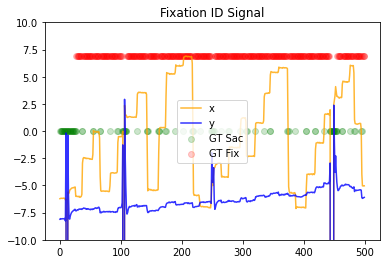

In [162]:
visualize_random_example(test_dl, vizualize_fix_signal)

In [113]:
def show_signal_on_screen_with_fixations(
                signal, 
                labels,
                screen_width=29.77,
                screen_height=17.09,
                resolution_magnifier=10,
                scatter_size = 5,
                off_screen_factor = 2,
                title=""):
  """
  
  
  Args:
    signal: 2D signal
    labels: 0 or 1 for saccade or fixation
    screen_width: unit is visual degrees
    screen_height: unit is visual degrees
    resolution_magnifier (int): magnify visualization 
    
  """

  # background image: * 2 for off-screen gazes
  img = np.zeros((int(screen_height * off_screen_factor * resolution_magnifier), int(screen_width * off_screen_factor * resolution_magnifier), 3),
                 dtype=np.float32)

  for i,(x, y) in enumerate(signal):
    xi = int(x * resolution_magnifier + screen_width * resolution_magnifier)
    yi = int(y * resolution_magnifier + screen_height * resolution_magnifier)

    try:
      label = labels[i]
      if label == 0:
        img[yi - scatter_size:yi + scatter_size+1, xi - scatter_size:xi + scatter_size+1, 1] += 0.9
      elif label == 1:
        img[yi - scatter_size:yi + scatter_size+1, xi - scatter_size:xi + scatter_size+1, 0] += 0.9
      else:
        raise Exception("Label was not 0 or 1")
    except Exception as e:
      print(e)

  img = np.clip(img, 0, 1)
  plt.imshow(img)

  plt.title(title)
  plt.show()

In [114]:
def get_random_example_from_dataloader(dl):
    x_batch, y_batch = next(iter(dl))
    x, y = x_batch[0], y_batch[0]
    return x, y

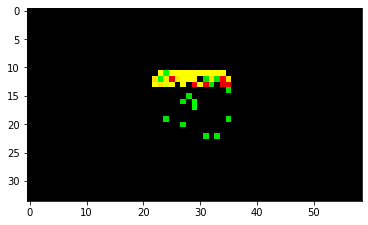

In [161]:
signal, labels = get_random_example_from_dataloader(test_dl)
show_signal_on_screen_with_fixations(signal, labels,resolution_magnifier=1,scatter_size=0, off_screen_factor=2)

## Model

In [34]:
pre_trained_weights_dir = Path("../OBF/pre_weights/sample_weights")

In [35]:
encoder = creator.load_encoder(str(pre_trained_weights_dir.resolve()))

Loading:  /Users/rickgentry/emotive_lab/eyemind/OBF/pre_weights/sample_weights/encoder_1633040995_gru.pt


In [11]:
print(encoder)

Sequential(
  (0): CNNEncoder(
    (cnn): Sequential(
      (0): ConvBlock(
        (conv): Conv1d(2, 14, kernel_size=(7,), stride=(1,), padding=(3,))
        (pool_layer): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
        (bn): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): LeakyReLU(negative_slope=0.01)
      )
      (1): ConvBlock(
        (conv): Conv1d(16, 16, kernel_size=(7,), stride=(1,), padding=(3,))
        (bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): LeakyReLU(negative_slope=0.01)
      )
    )
  )
  (1): RNNEncoder(
    (rnn): GRU(32, 128, num_layers=2, batch_first=True, dropout=0.1)
  )
)


In [12]:
fi_decoder = torch.load(str(Path(pre_trained_weights_dir, "fi_1633040995_gru.pt").resolve()),map_location=torch.device('cpu'))


In [13]:
from torchsummary import summary
print(fi_decoder)


RNNDecoder(
  (rnn): GRU(128, 128, num_layers=2, batch_first=True, dropout=0.1)
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out_fc): Linear(in_features=128, out_features=2, bias=True)
)


In [14]:
class FixationIdentifier(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        embeddings = self.encoder(x)
        output = self.decoder(embeddings)
        return output
        

In [15]:
fid_model = FixationIdentifier(encoder, fi_decoder)

In [16]:
print(fid_model)

FixationIdentifier(
  (encoder): Sequential(
    (0): CNNEncoder(
      (cnn): Sequential(
        (0): ConvBlock(
          (conv): Conv1d(2, 14, kernel_size=(7,), stride=(1,), padding=(3,))
          (pool_layer): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
          (bn): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): LeakyReLU(negative_slope=0.01)
        )
        (1): ConvBlock(
          (conv): Conv1d(16, 16, kernel_size=(7,), stride=(1,), padding=(3,))
          (bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): LeakyReLU(negative_slope=0.01)
        )
      )
    )
    (1): RNNEncoder(
      (rnn): GRU(32, 128, num_layers=2, batch_first=True, dropout=0.1)
    )
  )
  (decoder): RNNDecoder(
    (rnn): GRU(128, 128, num_layers=2, batch_first=True, dropout=0.1)
    (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [38]:
batch = next(iter(test_dl))

In [39]:
x,y = batch

In [58]:
logits = fid_model(x)

In [60]:
logits.softmax(dim=2).shape

torch.Size([8, 500, 2])

In [45]:
preds = logits.argmax(dim=2).detach().cpu().numpy().reshape(-1)

In [61]:
probs = logits.softmax(dim=2)[:,:,1].detach().cpu().numpy().reshape(-1)

In [64]:
y = y.cpu().numpy().reshape(-1)

In [66]:
auc = metrics.roc_auc_score(y, probs)

In [67]:
auc

0.6506709492371336

In [68]:
acc = metrics.accuracy_score(y, preds)


In [69]:
acc

0.73525

In [93]:
import sklearn.metrics as metrics
import tqdm

def evaluate(dl, model):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    for x, y in tqdm.tqdm(dl):
        logits = model(x)
        preds = logits.argmax(dim=2).detach().cpu().numpy().reshape(-1)
        probs = logits.softmax(dim=2)[:,:,1].detach().cpu().numpy().reshape(-1)
        y = y.cpu().numpy().reshape(-1)
        all_preds += preds.tolist()
        all_labels += y.tolist()
        all_probs += probs.tolist()
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    all_preds = np.array(all_preds)
    masked_indices = all_labels == -1
    acc = metrics.accuracy_score(all_labels[~masked_indices], all_preds[~masked_indices])
    auc = metrics.roc_auc_score(all_labels[~masked_indices], all_probs[~masked_indices])
    return acc, auc





In [72]:
preds, labels, probs = evaluate(test_dl, fid_model)

100%|██████████| 784/784 [08:00<00:00,  1.63it/s]


In [91]:
preds = np.array(preds)
acc = metrics.accuracy_score(labels[~indices_masked], preds[~indices_masked])


In [92]:
acc

0.7467187887901037

In [81]:
labels = np.array(labels)

In [86]:
probs = np.array(probs)

In [88]:
auc = metrics.roc_auc_score(labels[~indices_masked], probs[~indices_masked])

In [89]:
auc

0.6525304778413941

### Fixation Analysis

In [1]:
import yaml
from pathlib import Path
from eyemind.dataloading.gaze_data import BaseSequenceToSequenceDataModule
from eyemind.dataloading.informer_data import InformerDataModule
import torch

def load_model_from_checkpoint(model_cls, checkpoint_path):
    return model_cls.load_from_checkpoint(checkpoint_path)

def get_dataloader(dataloader_cls, config_path, data_base_dir="/Users/rickgentry/emotive_lab/eyemind/data", label_filepath="processed/EML1_pageLevel_with_filename_seq.csv", data_dir="processed/fixation"):
    with open(config_path, "r") as f:
        config = yaml.safe_load(f)
    config["data"]["data_dir"] = str(Path(data_base_dir, data_dir).resolve())
    config["data"]["label_filepath"] = str(Path(data_base_dir, label_filepath).resolve())
    dm = dataloader_cls(**config['data'])
    dm.setup()
    return dm.predict_dataloader()

def get_prediction_targets(model, dl, samples=1):
    model.eval()
    batch = next(iter(dl))
    logits = model.forward(batch[0])
    print(logits.shape)
    fixation_preds = model._get_preds(logits)
    print(fixation_preds.shape)
    fixation_targets = batch[1]
    rows = torch.randint(high=len(fixation_preds),size=(samples,))
    return fixation_preds[rows].squeeze(), fixation_targets[rows].squeeze()

/Users/rickgentry/miniforge3/envs/eyemind/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [50]:
from eyemind.models.encoder_decoder import VariableSequenceLengthEncoderDecoderModel
model = load_model_from_checkpoint(VariableSequenceLengthEncoderDecoderModel, "/Users/rickgentry/emotive_lab/eyemind/lightning_logs/fixation_seq500_200epochs/checkpoints/epoch=199-step=3400.ckpt")

In [51]:
dl = get_dataloader(BaseSequenceToSequenceDataModule,"/Users/rickgentry/emotive_lab/eyemind/lightning_logs/fixation_seq500_200epochs/config.yaml")

In [52]:
preds, targets = get_prediction_targets(model, dl,samples=4)

torch.Size([64, 500, 2])
torch.Size([64, 500])


In [2]:
from eyemind.models.transformers import InformerEncoderFixationModel
informer_model = load_model_from_checkpoint(InformerEncoderFixationModel, "/Users/rickgentry/emotive_lab/eyemind/lightning_logs/fixation_informer_seq500_epochs120/checkpoints/epoch=120-step=2057.ckpt")

/Users/rickgentry/miniforge3/envs/eyemind/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [3]:
informer_dl = get_dataloader(InformerDataModule ,"/Users/rickgentry/emotive_lab/eyemind/lightning_logs/fixation_informer_seq500_epochs120/config.yaml")

In [4]:
informer_preds, informer_targets = get_prediction_targets(informer_model, informer_dl, 4)

torch.Size([64, 500, 2])
torch.Size([64, 500])


In [6]:
informer_preds.shape,informer_targets.shape

(torch.Size([4, 500]), torch.Size([4, 500]))

In [7]:
import matplotlib.pyplot as plt
import numpy as np
def plot_figures(preds, targets):
    num_plots = len(preds)
    rows = (num_plots // 5) + 1
    cols = 5
    plt.figure(0)
    for i in range(rows):
        for j in range(cols):
            ax = plt.subplot2grid((rows,cols), (i,j))
            ax.step(np.arange(len(preds[0])),targets[j * i].numpy(), preds[j * i].numpy())
    plt.show()

In [8]:
plot_figures(preds, targets)

NameError: name 'preds' is not defined

In [42]:
import matplotlib.patches as mpatches



def fixation_image(pred,target, title="Fixation Identification"):
    sl = len(pred)
    fixation_labels = torch.cat((pred.expand(sl//2,sl),target.expand(sl//2,sl)))
    plt.imshow(fixation_labels, extent=[0, len(fixation_labels[1]),0, 100], cmap='Greys')
    # plt.xticks(np.arange(0, len(fixation_labels), 1), [])
    plt.yticks([])
    # plt.grid(True, axis='x', lw=1, c='black')
    # plt.tick_params(axis='x', length=0)
    plt.title(title)
    black = mpatches.Patch(color='black', label='Fixation')
    white = mpatches.Patch(color='white', label='Saccade')
    plt.legend(handles=[black, white],bbox_to_anchor=(1.15, 1), loc='upper right')
    plt.xlabel("Time Steps (100 steps ~ 1.7s)")
    plt.show()

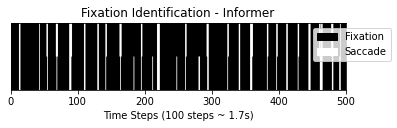

In [45]:
fixation_image(informer_preds[1], informer_targets[1], "Fixation Identification - Informer")

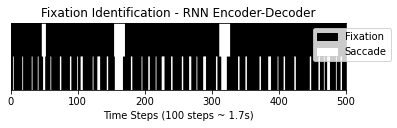

In [53]:
fixation_image(preds[1], targets[1], "Fixation Identification - RNN Encoder-Decoder")

In [29]:
preds.shape

torch.Size([100])

In [96]:
# Create datamodule
import yaml
from eyemind.dataloading.gaze_data import BaseSequenceToSequenceDataModule
config_path = "/Users/rickgentry/emotive_lab/eyemind/lightning_logs/version_11471837/config.yaml"
local_data_dir = "/Users/rickgentry/emotive_lab/eyemind/data/processed/fixation"
local_label_filepath = "/Users/rickgentry/emotive_lab/eyemind/data/processed/EML1_pageLevel_with_filename_seq.csv"
with open(config_path, "r") as f:
    config = yaml.safe_load(f)
config["data"]["data_dir"] = local_data_dir
config["data"]["label_filepath"] = local_label_filepath
dm = BaseSequenceToSequenceDataModule(**config['data'])


In [62]:
dm.setup()


In [5]:
predict_dl = dm.predict_dataloader()

In [ ]:
get_prediction_targets()

In [5]:
from pytorch_lightning import Trainer
config["trainer"]["accelerator"] = "cpu"
trainer = Trainer(**config["trainer"])

/Users/rickgentry/miniforge3/envs/eyemind/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
batch = next(iter(predict_dl))
preds = model.predict_step(batch, 0)
fixation_preds = preds["fi"]
fixation_targets = batch[1]


In [18]:
import numpy as np
row = np.random.randint(0, len(fixation_preds))

In [20]:
pred, target = fixation_preds[row], fixation_targets[row]

In [ ]:
def vizualize_fix_signal(inputs, fixations, lims=(-10,10), title="Fixation ID Signal"):

    n1 = inputs.shape[0]
    max_val = inputs.max()

    # The input sequence
    plt.plot(list(range(n1)),
            inputs[:, 0],
            label="x",
            color="orange",
            alpha=0.8)
    plt.plot(list(range(n1)),
            inputs[:, 1],
            label="y",
            color="blue",
            alpha=0.8)

    # The Ground truth sequence
    saccade_gt_time = np.where(fixations == 0)[0]
    plt.scatter(saccade_gt_time,
                saccade_gt_time * 0,
                label="GT Sac",
                color="green",
                alpha=0.2)
    fix_gt_time = np.where(fixations == 1)[0]
    plt.scatter(fix_gt_time,
                np.ones((len(fix_gt_time),)) * max_val,
                label="GT Fix",
                color="red",
                alpha=0.2)
    plt.ylim(*lims)
    plt.title(title)
    plt.legend()
    plt.show()
                

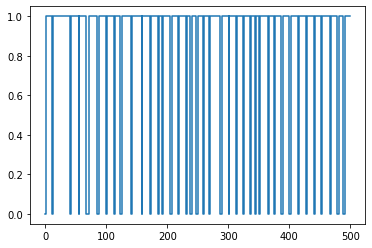

In [24]:
import matplotlib.pyplot as plt
target.numpy()
plt.step(np.arange(len(target)),target.numpy())    


In [54]:
def avg_fixation_len(fixations):
    i = 0
    fix_lens = []
    while i < len(fixations):
        if fixations[i]:
            j = i
            while j < len(fixations) and fixations[j]:
                j+=1
            fix_lens.append(j - i)
            i = j
        else: 
            i+= 1
    if len(fix_lens) == 0:
        return 500, 0
    return sum(fix_lens) / len(fix_lens), len(fix_lens)

def avg_saccade_len(fixations):
    i = 0
    saccade_lens = []
    while i < len(fixations):
        if fixations[i] == 0:
            j = i
            while j < len(fixations) and fixations[j] == 0:
                j+=1
            saccade_lens.append(j - i)
            i = j
        else: 
            i+= 1
    return sum(saccade_lens) / len(saccade_lens), len(saccade_lens)

In [41]:
saccade_lens = []
for s in fixation_targets:
    saccade_lens.append(avg_saccade_len(s)*17)
print(saccade_lens)

[37.035714285714285, 30.161290322580644, 34.56666666666666, 57.31428571428572, 44.5, 62.33333333333333, 30.161290322580644, 136.0, 42.5, 68.48571428571428, 39.3125, 36.74193548387097, 35.94285714285714, 56.51351351351351, 91.47619047619048, 30.174999999999997, 38.371428571428574, 68.53125, 43.714285714285715, 35.36, 55.935483870967744, 29.363636363636363, 62.33333333333333, 32.62162162162162, 55.935483870967744, 221.0, 38.13513513513514, 39.5, 27.685714285714287, 34.54838709677419, 32.62162162162162, 36.91428571428571, 26.633333333333333, 33.56410256410257, 33.028571428571425, 43.27272727272727, 49.82758620689655, 39.84375, 28.609756097560975, 38.146341463414636, 65.65517241379311, 240.0, 30.161290322580644, 36.17948717948718, 56.230769230769226, 63.628571428571426, 43.714285714285715, 70.61538461538463, 72.25, 349.5625, 51.0, 45.769230769230774, 30.5, 44.766666666666666, 41.93333333333334, 51.58620689655172, 34.91891891891892, 42.282051282051285, 46.21875, 99.38461538461537, 102.65384

In [56]:
avg_fixations = []
for s in fixation_preds:
    avg_fixations.append(avg_fixation_len(s)[1])
print(avg_fixations)

[1, 1, 1, 6, 1, 1, 1, 0, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 10, 1, 1, 5, 1, 1, 1, 6, 1, 1, 1, 0, 3, 28, 1, 2]


In [55]:
num_fix = []
for s in fixation_targets:
    num_fix.append(avg_fixation_len(s)[1])
print(num_fix)

[28, 32, 31, 34, 34, 28, 32, 22, 34, 35, 33, 31, 36, 38, 22, 40, 35, 33, 29, 26, 32, 23, 27, 37, 32, 19, 38, 34, 36, 32, 38, 36, 30, 40, 36, 33, 30, 31, 41, 42, 30, 17, 32, 39, 39, 34, 29, 26, 29, 15, 30, 40, 34, 31, 31, 29, 38, 40, 33, 27, 27, 37, 33, 34]


In [46]:
avg_fixation_len(pred)

500.0

In [42]:
#target = target.numpy()
plt.imshow(target.reshape(1, -1), extent=[0, len(target), 0, 1], cmap='Greys')
plt.xticks(np.arange(0, len(target), 1), [])
plt.yticks([])
plt.grid(True, axis='x', lw=1, c='black')
plt.tick_params(axis='x', length=0)

plt.show()
